# Diabetes Prediction: Modeling

In this notebook, we'll develop and evaluate baseline models for diabetes prediction based on our preprocessed data.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
from pathlib import Path

# Machine learning imports
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, average_precision_score
)

# Visualization settings
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette('viridis')

# For reproducibility
np.random.seed(42)


In [3]:
# Load preprocessed data
print("Loading preprocessed data...")

data_path = Path("data/preprocessed_data.pkl")
scaled_data_path = Path("data/scaled_data.pkl")

# Load the preprocessed data
with open(data_path, "rb") as f:
    preprocessed_data = pickle.load(f)

# Load the scaled data
with open(scaled_data_path, "rb") as f:
    scaled_data = pickle.load(f)

# Extract the datasets
X_train = preprocessed_data['X_train']
X_test = preprocessed_data['X_test']
y_train = preprocessed_data['y_train']
y_test = preprocessed_data['y_test']
feature_names = preprocessed_data['feature_names']

# Extract the scaled datasets
X_train_std = scaled_data['X_train_std']
X_test_std = scaled_data['X_test_std']
X_train_minmax = scaled_data['X_train_minmax']
X_test_minmax = scaled_data['X_test_minmax']

print(f"Training data shape: {X_train.shape if hasattr(X_train, 'shape') else len(X_train)}")
print(f"Testing data shape: {X_test.shape if hasattr(X_test, 'shape') else len(X_test)}")
print(f"Number of features: {len(feature_names)}")
print(f"Selected features: {feature_names}")

# Check class balance
train_class_dist = pd.Series(y_train).value_counts(normalize=True)
test_class_dist = pd.Series(y_test).value_counts(normalize=True)
print("\nClass distribution:")
print(f"Training set: {train_class_dist.to_dict()}")
print(f"Testing set: {test_class_dist.to_dict()}")


Loading preprocessed data...
Training data shape: (55245, 15)
Testing data shape: (13812, 15)
Number of features: 15
Selected features: ['Health_Risk_Score', 'BMI', 'GenHlth', 'Age', 'HighBP', 'Income', 'BMI_Category', 'HighChol', 'PhysHlth', 'Age_Group', 'DiffWalk', 'Education', 'HeartDiseaseorAttack', 'MentHlth', 'Lifestyle_Score']

Class distribution:
Training set: {1.0: 0.5082269888677708, 0.0: 0.49177301113222915}
Testing set: {1.0: 0.5082536924413553, 0.0: 0.4917463075586447}


In [4]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Evaluate a model's performance with multiple metrics
    
    Parameters:
    -----------
    model : sklearn model
        The trained model to evaluate
    X_train : array-like
        Training features
    X_test : array-like
        Testing features
    y_train : array-like
        Training labels
    y_test : array-like
        Testing labels
    model_name : str
        Name of the model for reporting
        
    Returns:
    --------
    dict
        Dictionary containing evaluation metrics
    """
    # Start timing
    start_time = time.time()
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Cross-validation score
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Calculate execution time
    exec_time = time.time() - start_time
    
    # ROC AUC score
    roc_auc = None
    if y_pred_proba is not None:
        roc_auc = auc(roc_curve(y_test, y_pred_proba)[0], roc_curve(y_test, y_pred_proba)[1])
    
    # Return metrics as dictionary
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'cv_f1_mean': cv_scores.mean(),
        'cv_f1_std': cv_scores.std(),
        'confusion_matrix': cm,
        'roc_auc': roc_auc,
        'execution_time': exec_time,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

def plot_model_results(metrics, model_name):
    """
    Plot evaluation results for a model
    
    Parameters:
    -----------
    metrics : dict
        Dictionary containing evaluation metrics
    model_name : str
        Name of the model for plotting
    """
    # Create a figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot confusion matrix
    sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Diabetes', 'Diabetes'],
                yticklabels=['No Diabetes', 'Diabetes'], ax=ax1)
    ax1.set_xlabel('Predicted Label')
    ax1.set_ylabel('True Label')
    ax1.set_title(f'Confusion Matrix - {model_name}')
    
    # Plot performance metrics
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score', 'cv_f1_mean']
    values = [metrics[m] for m in metrics_to_plot]
    
    # Create bar plot
    bars = ax2.bar(metrics_to_plot, values, color='skyblue')
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.3f}', ha='center', va='bottom')
    
    ax2.set_ylim(0, 1.1)
    ax2.set_title(f'Performance Metrics - {model_name}')
    ax2.set_ylabel('Score')
    
    plt.tight_layout()
    plt.show()
    
    # Print additional information
    print(f"Model: {model_name}")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    print(f"Cross-Validation F1 Score: {metrics['cv_f1_mean']:.4f} ± {metrics['cv_f1_std']:.4f}")
    if metrics['roc_auc'] is not None:
        print(f"ROC AUC: {metrics['roc_auc']:.4f}")
    print(f"Execution Time: {metrics['execution_time']:.4f} seconds")
    print("\nClassification Report:")
    print(classification_report(y_test, metrics['y_pred']))
    
    # Plot ROC curve if probabilities are available
    if metrics['y_pred_proba'] is not None:
        plt.figure(figsize=(8, 6))
        fpr, tpr, _ = roc_curve(y_test, metrics['y_pred_proba'])
        plt.plot(fpr, tpr, label=f'ROC curve (area = {metrics["roc_auc"]:.3f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc="lower right")
        plt.show()
        
        # Plot precision-recall curve
        plt.figure(figsize=(8, 6))
        precision, recall, _ = precision_recall_curve(y_test, metrics['y_pred_proba'])
        avg_precision = average_precision_score(y_test, metrics['y_pred_proba'])
        plt.plot(recall, precision, label=f'AP = {avg_precision:.3f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve - {model_name}')
        plt.legend(loc="lower left")
        plt.grid(True)
        plt.show()

# Initialize results table
results_table = []


## 1. Logistic Regression

Logistic Regression is an excellent baseline model for binary classification problems. It's interpretable, fast to train, and provides probability estimates.

### 1.1 Basic Logistic Regression


Training Logistic Regression model...


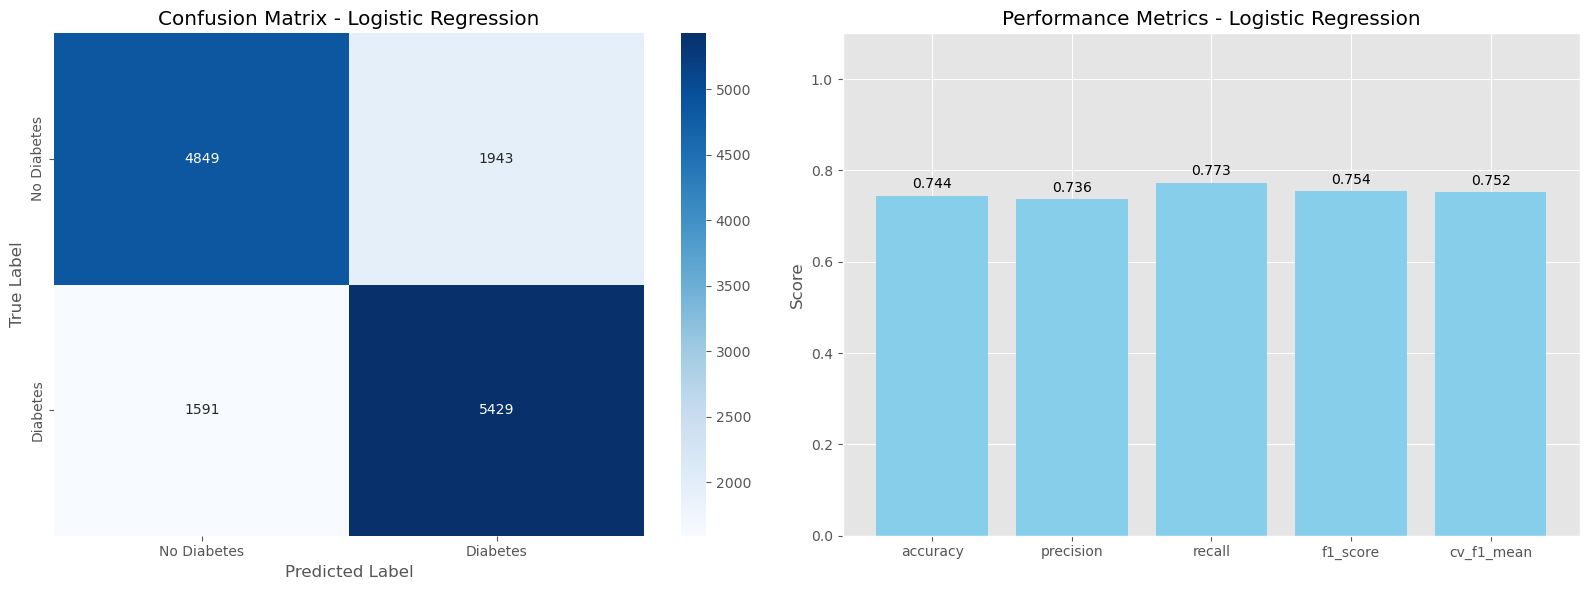

Model: Logistic Regression
Accuracy: 0.7441
Precision: 0.7364
Recall: 0.7734
F1 Score: 0.7544
Cross-Validation F1 Score: 0.7516 ± 0.0048
ROC AUC: 0.8154
Execution Time: 0.2159 seconds

Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.71      0.73      6792
         1.0       0.74      0.77      0.75      7020

    accuracy                           0.74     13812
   macro avg       0.74      0.74      0.74     13812
weighted avg       0.74      0.74      0.74     13812



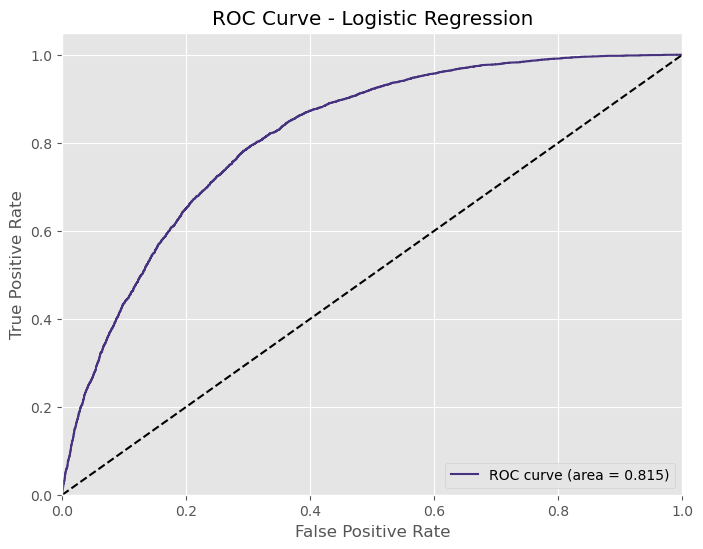

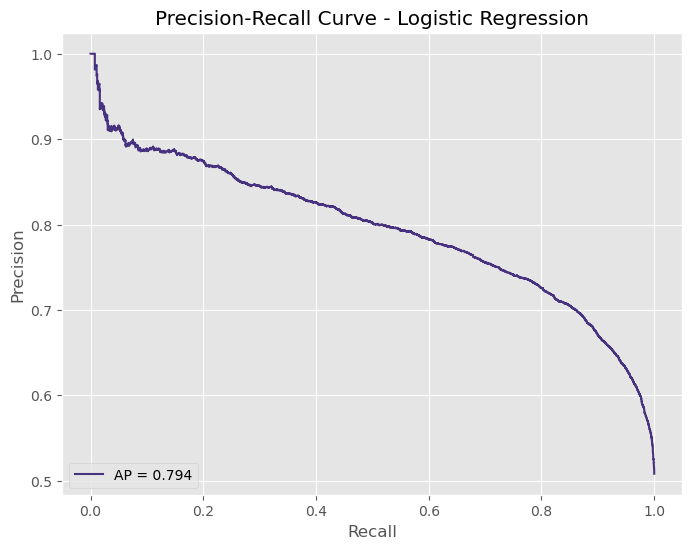

In [4]:
# Create a pipeline with StandardScaler and Logistic Regression
# Since Logistic Regression is sensitive to feature scaling, we'll use the scaled data
print("Training Logistic Regression model...")

# Create and train the model
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Fit the model
lr_pipeline.fit(X_train, y_train)

# Evaluate the model
lr_metrics = evaluate_model(lr_pipeline, X_train, X_test, y_train, y_test, "Logistic Regression")

# Plot results
plot_model_results(lr_metrics, "Logistic Regression")

# Add to results table
results_table.append({
    'Model': 'Logistic Regression',
    'Accuracy': lr_metrics['accuracy'],
    'Precision': lr_metrics['precision'],
    'Recall': lr_metrics['recall'],
    'F1 Score': lr_metrics['f1_score'],
    'CV F1 Score': f"{lr_metrics['cv_f1_mean']:.4f} ± {lr_metrics['cv_f1_std']:.4f}",
    'ROC AUC': lr_metrics['roc_auc'],
    'Execution Time (s)': lr_metrics['execution_time']
})


### 1.2 Logistic Regression with Hyperparameter Tuning


Tuning Logistic Regression hyperparameters...
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters: {'classifier__C': 0.001, 'classifier__max_iter': 1000, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}
Best F1 score: 0.7523


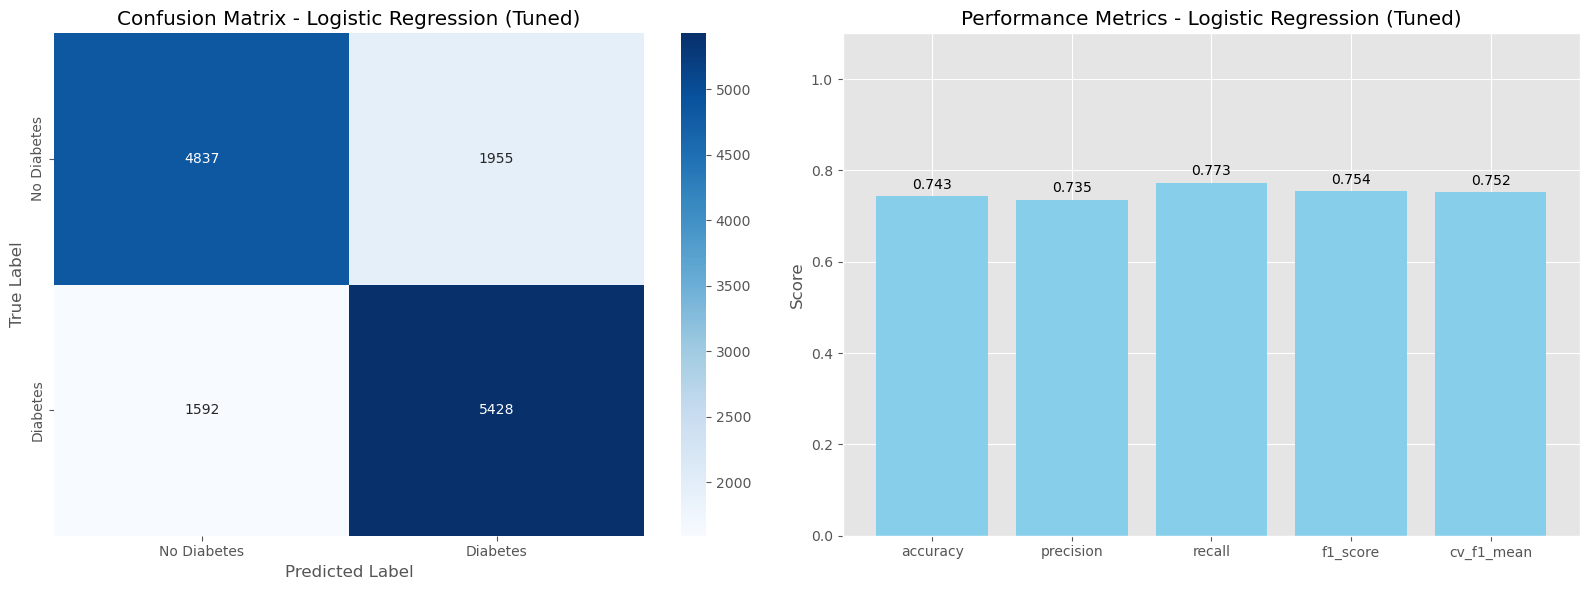

Model: Logistic Regression (Tuned)
Accuracy: 0.7432
Precision: 0.7352
Recall: 0.7732
F1 Score: 0.7537
Cross-Validation F1 Score: 0.7523 ± 0.0040
ROC AUC: 0.8153
Execution Time: 0.5911 seconds

Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.71      0.73      6792
         1.0       0.74      0.77      0.75      7020

    accuracy                           0.74     13812
   macro avg       0.74      0.74      0.74     13812
weighted avg       0.74      0.74      0.74     13812



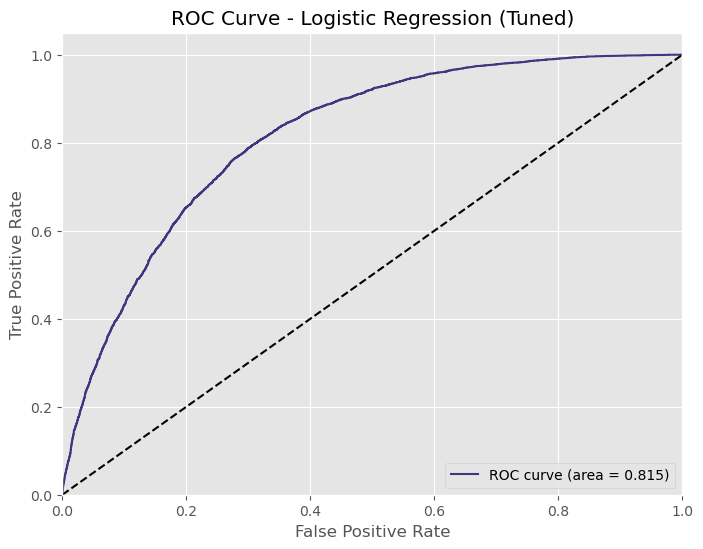

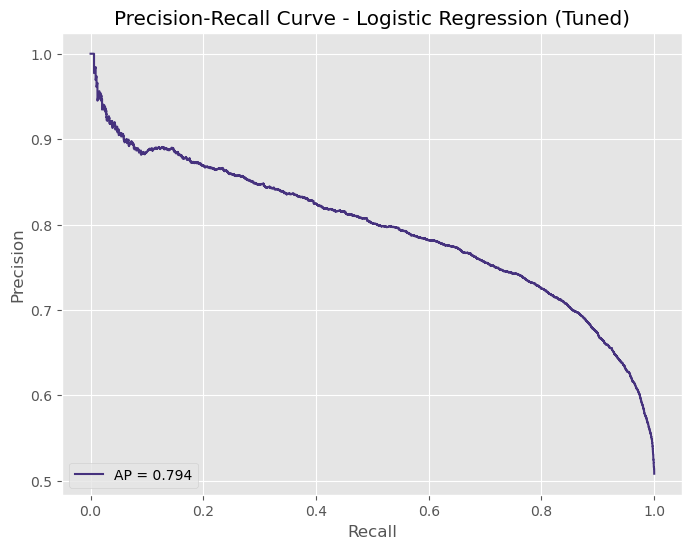

In [10]:
# Tune hyperparameters for Logistic Regression
print("Tuning Logistic Regression hyperparameters...")

# Define the pipeline
lr_tuned_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42))
])

# Define the parameter grid
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2', 'elasticnet', None],
    'classifier__solver': ['liblinear', 'saga', 'lbfgs'],
    'classifier__max_iter': [1000],
    'classifier__l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}

# Remove incompatible parameter combinations
param_grid_filtered = []
for penalty in param_grid['classifier__penalty']:
    for solver in param_grid['classifier__solver']:
        for C in param_grid['classifier__C']:
            for max_iter in param_grid['classifier__max_iter']:
                # Check compatibility
                if penalty == 'l1' and solver not in ['liblinear', 'saga']:
                    continue
                if penalty == 'elasticnet' and solver != 'saga':
                    continue
                if penalty is None and solver == 'liblinear':
                    continue
                if penalty== 'elasticnet' and solver == 'liblinear':
                    continue
                
                # Only include l1_ratio for elasticnet penalty
                if penalty == 'elasticnet':
                    for l1_ratio in param_grid['classifier__l1_ratio']:
                        param_grid_filtered.append({
                            'classifier__C': [C],
                            'classifier__penalty': [penalty],
                            'classifier__solver': [solver],
                            'classifier__max_iter': [max_iter],
                            'classifier__l1_ratio': [l1_ratio],
                        })
                else:
                    # For other penalties, don't include l1_ratio
                    param_grid_filtered.append({
                        'classifier__C': [C],
                        'classifier__penalty': [penalty],
                        'classifier__solver': [solver],
                        'classifier__max_iter': [max_iter],
                    })

# Create GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    lr_tuned_pipeline,
    param_grid_filtered,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best model
lr_tuned = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best F1 score: {grid_search.best_score_:.4f}")

# Evaluate the tuned model
lr_tuned_metrics = evaluate_model(lr_tuned, X_train, X_test, y_train, y_test, "Logistic Regression (Tuned)")

# Plot results
plot_model_results(lr_tuned_metrics, "Logistic Regression (Tuned)")

# Add to results table
results_table.append({
    'Model': 'Logistic Regression (Tuned)',
    'Accuracy': lr_tuned_metrics['accuracy'],
    'Precision': lr_tuned_metrics['precision'],
    'Recall': lr_tuned_metrics['recall'],
    'F1 Score': lr_tuned_metrics['f1_score'],
    'CV F1 Score': f"{lr_tuned_metrics['cv_f1_mean']:.4f} ± {lr_tuned_metrics['cv_f1_std']:.4f}",
    'ROC AUC': lr_tuned_metrics['roc_auc'],
    'Execution Time (s)': lr_tuned_metrics['execution_time']
})


### 1.3 Logistic Regression Feature Importance


Extracting feature importance from Logistic Regression...


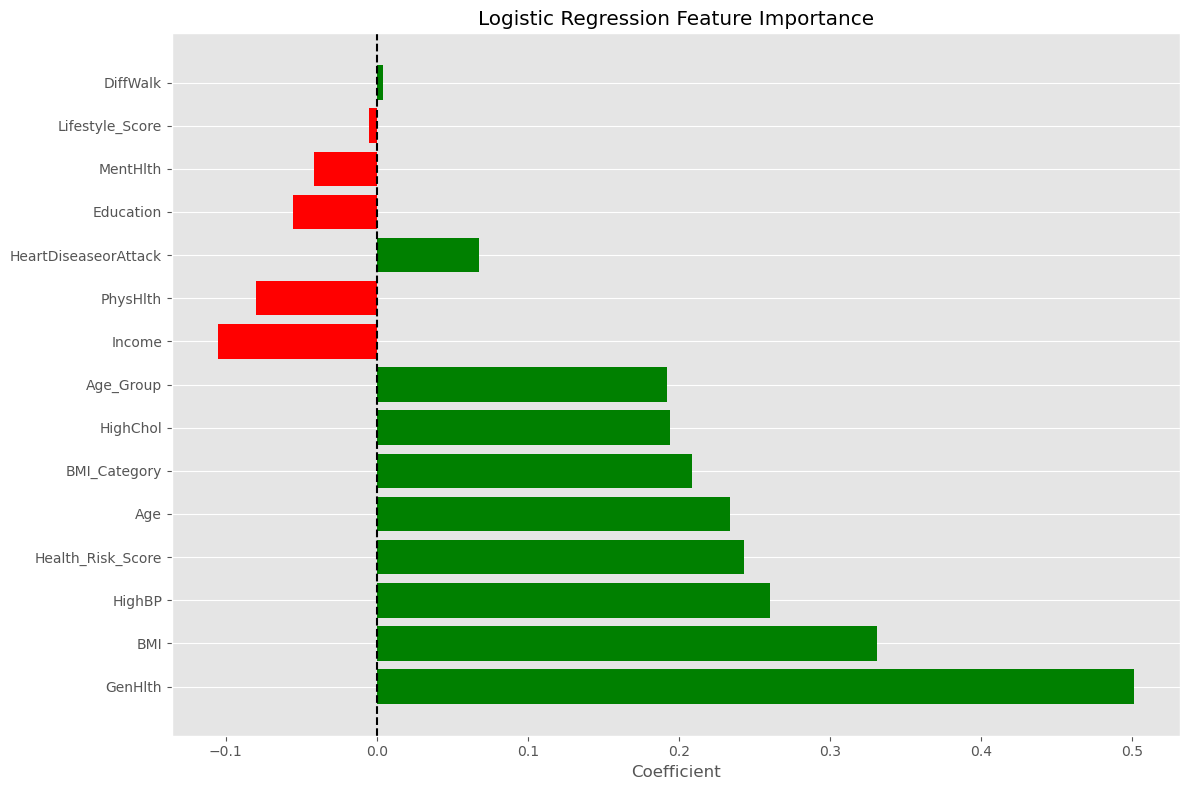

Top 5 positive features (increasing diabetes risk):
             Feature  Coefficient  Abs_Coefficient
2            GenHlth     0.501376         0.501376
1                BMI     0.331337         0.331337
4             HighBP     0.260067         0.260067
0  Health_Risk_Score     0.242790         0.242790
3                Age     0.233498         0.233498

Top 5 negative features (decreasing diabetes risk):
            Feature  Coefficient  Abs_Coefficient
5            Income    -0.105350         0.105350
8          PhysHlth    -0.079670         0.079670
11        Education    -0.055549         0.055549
13         MentHlth    -0.041668         0.041668
14  Lifestyle_Score    -0.005261         0.005261


In [6]:
# Extract feature importance from Logistic Regression
print("Extracting feature importance from Logistic Regression...")

# Get the coefficients
if hasattr(lr_tuned['classifier'], 'coef_'):
    coef = lr_tuned['classifier'].coef_[0]
    
    # Create a DataFrame with features and coefficients
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coef,
        'Abs_Coefficient': np.abs(coef)
    })
    
    # Sort by absolute coefficient value
    feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    colors = ['red' if c < 0 else 'green' for c in feature_importance['Coefficient']]
    plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color=colors)
    plt.xlabel('Coefficient')
    plt.title('Logistic Regression Feature Importance')
    plt.axvline(x=0, color='black', linestyle='--')
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()
    
    # Print top positive and negative features
    print("Top 5 positive features (increasing diabetes risk):")
    print(feature_importance[feature_importance['Coefficient'] > 0].head(5))
    
    print("\nTop 5 negative features (decreasing diabetes risk):")
    print(feature_importance[feature_importance['Coefficient'] < 0].head(5))
else:
    print("Could not extract coefficients from the model.")


## 2. Decision Tree

Decision Trees are simple yet powerful models that can capture non-linear relationships. They're also highly interpretable as they can be visualized as a tree structure.


Training Decision Tree model...


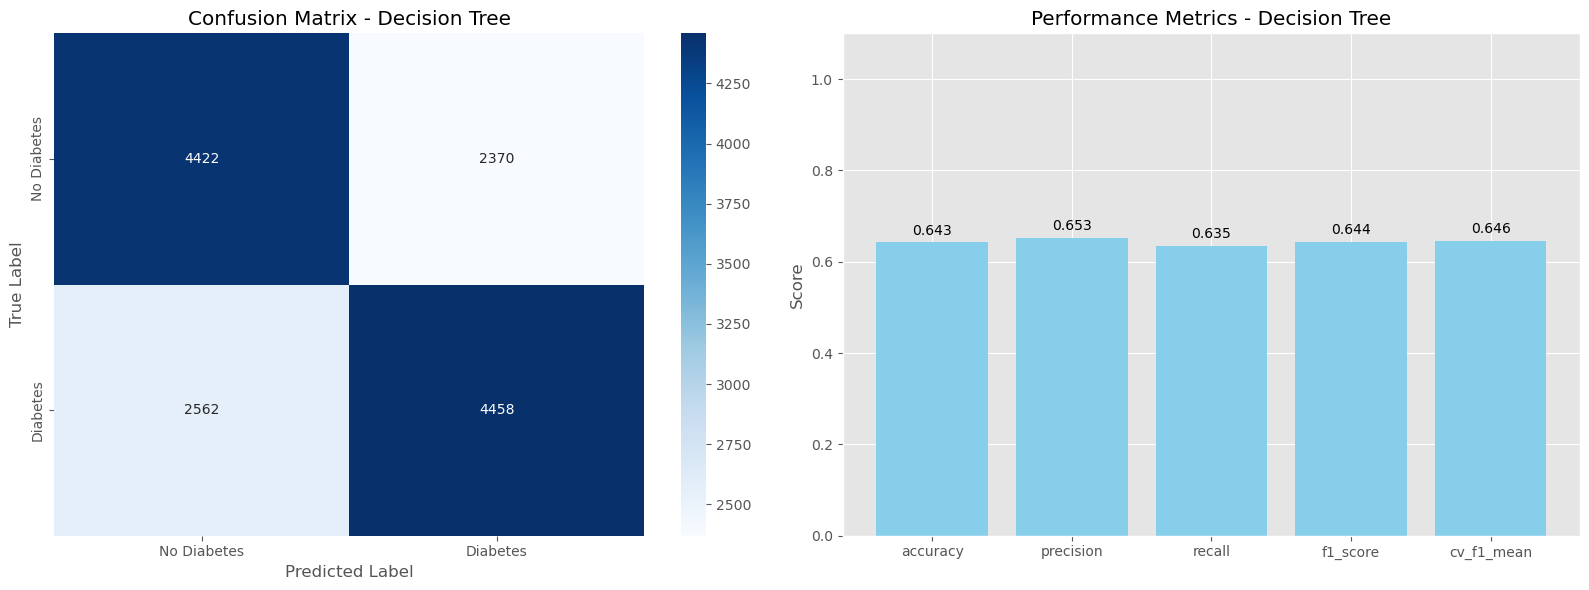

Model: Decision Tree
Accuracy: 0.6429
Precision: 0.6529
Recall: 0.6350
F1 Score: 0.6438
Cross-Validation F1 Score: 0.6457 ± 0.0026
ROC AUC: 0.6462
Execution Time: 0.6575 seconds

Classification Report:
              precision    recall  f1-score   support

         0.0       0.63      0.65      0.64      6792
         1.0       0.65      0.64      0.64      7020

    accuracy                           0.64     13812
   macro avg       0.64      0.64      0.64     13812
weighted avg       0.64      0.64      0.64     13812



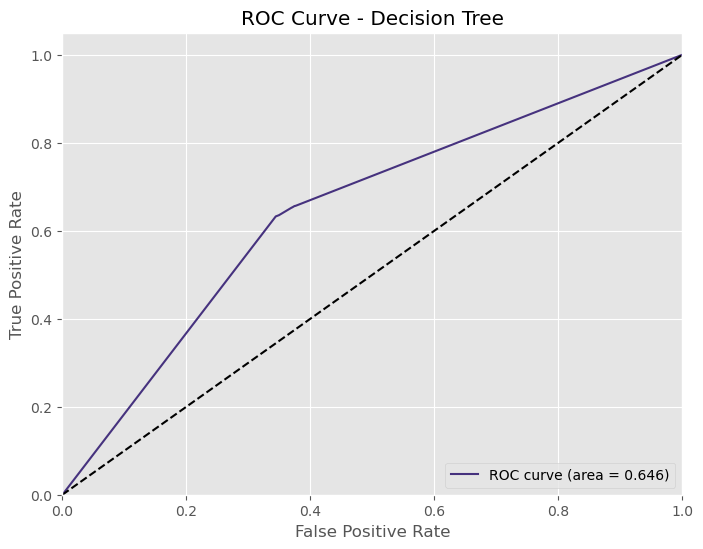

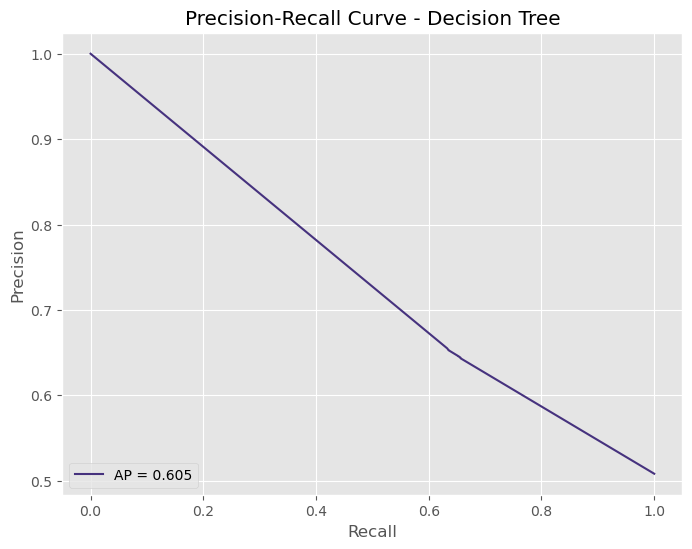

In [5]:
# Decision trees don't require feature scaling, so we use the original data
print("Training Decision Tree model...")

# Create and train the model
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Evaluate the model
dt_metrics = evaluate_model(dt, X_train, X_test, y_train, y_test, "Decision Tree")

# Plot results
plot_model_results(dt_metrics, "Decision Tree")

# Add to results table
results_table.append({
    'Model': 'Decision Tree',
    'Accuracy': dt_metrics['accuracy'],
    'Precision': dt_metrics['precision'],
    'Recall': dt_metrics['recall'],
    'F1 Score': dt_metrics['f1_score'],
    'CV F1 Score': f"{dt_metrics['cv_f1_mean']:.4f} ± {dt_metrics['cv_f1_std']:.4f}",
    'ROC AUC': dt_metrics['roc_auc'],
    'Execution Time (s)': dt_metrics['execution_time']
})


### 2.1 Decision Tree with Hyperparameter Tuning


Tuning Decision Tree hyperparameters...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best F1 score: 0.7507


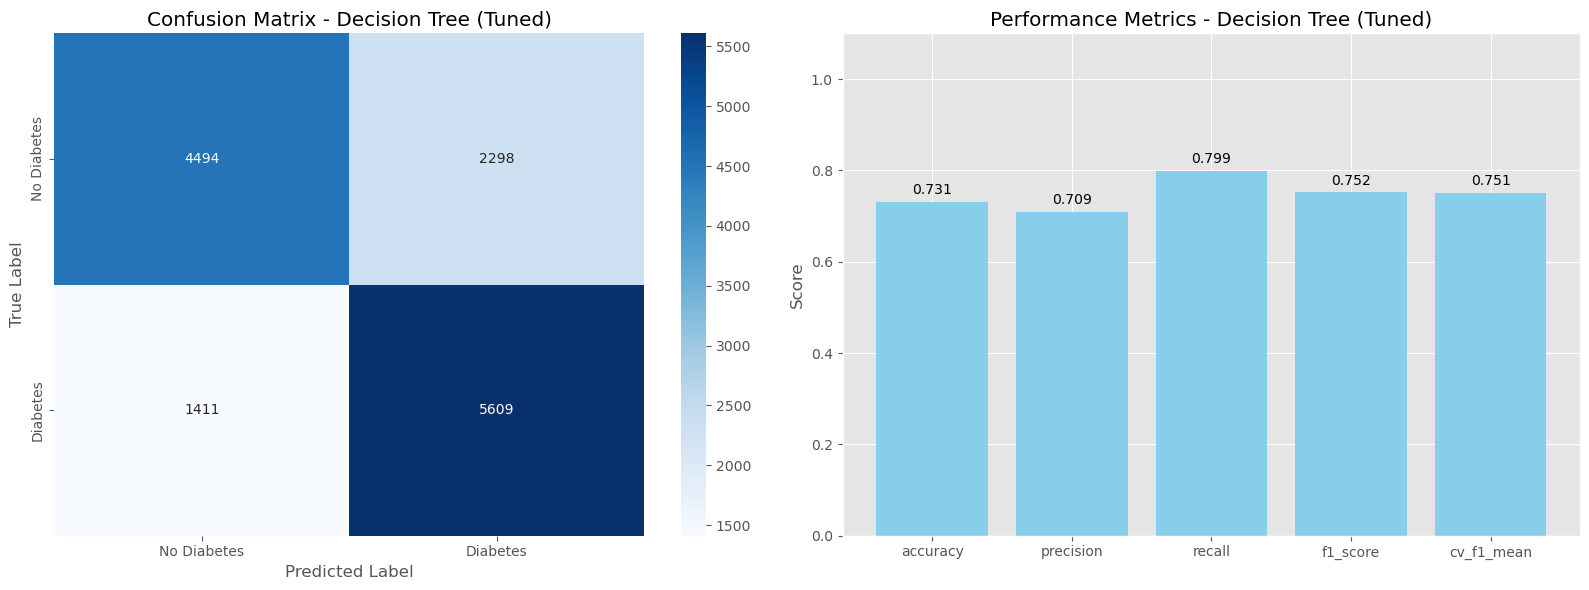

Model: Decision Tree (Tuned)
Accuracy: 0.7315
Precision: 0.7094
Recall: 0.7990
F1 Score: 0.7515
Cross-Validation F1 Score: 0.7507 ± 0.0055
ROC AUC: 0.7968
Execution Time: 0.3767 seconds

Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.66      0.71      6792
         1.0       0.71      0.80      0.75      7020

    accuracy                           0.73     13812
   macro avg       0.74      0.73      0.73     13812
weighted avg       0.73      0.73      0.73     13812



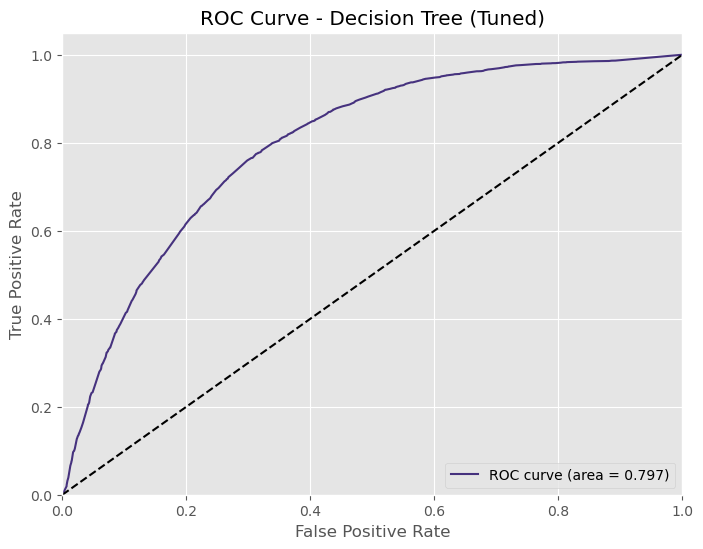

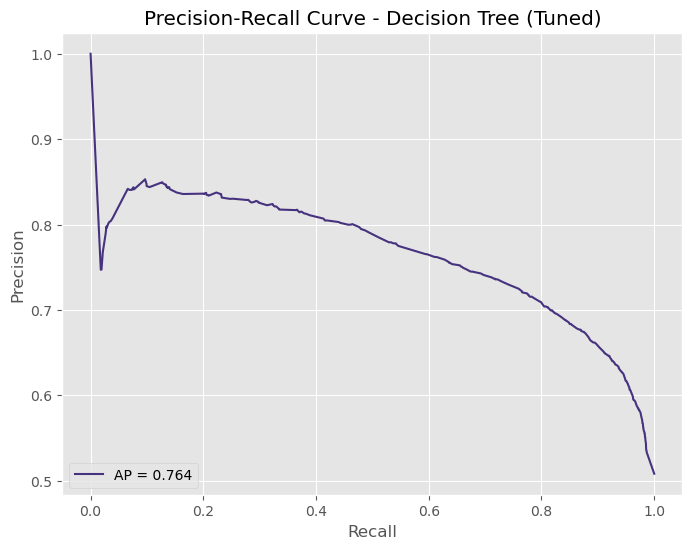

In [6]:
# Tune hyperparameters for Decision Tree
print("Tuning Decision Tree hyperparameters...")

# Define parameter grid
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Create GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best model
dt_tuned = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best F1 score: {grid_search.best_score_:.4f}")

# Evaluate the tuned model
dt_tuned_metrics = evaluate_model(dt_tuned, X_train, X_test, y_train, y_test, "Decision Tree (Tuned)")

# Plot results
plot_model_results(dt_tuned_metrics, "Decision Tree (Tuned)")

# Add to results table
results_table.append({
    'Model': 'Decision Tree (Tuned)',
    'Accuracy': dt_tuned_metrics['accuracy'],
    'Precision': dt_tuned_metrics['precision'],
    'Recall': dt_tuned_metrics['recall'],
    'F1 Score': dt_tuned_metrics['f1_score'],
    'CV F1 Score': f"{dt_tuned_metrics['cv_f1_mean']:.4f} ± {dt_tuned_metrics['cv_f1_std']:.4f}",
    'ROC AUC': dt_tuned_metrics['roc_auc'],
    'Execution Time (s)': dt_tuned_metrics['execution_time']
})


### 2.2 Visualize Decision Tree


Visualizing Decision Tree...


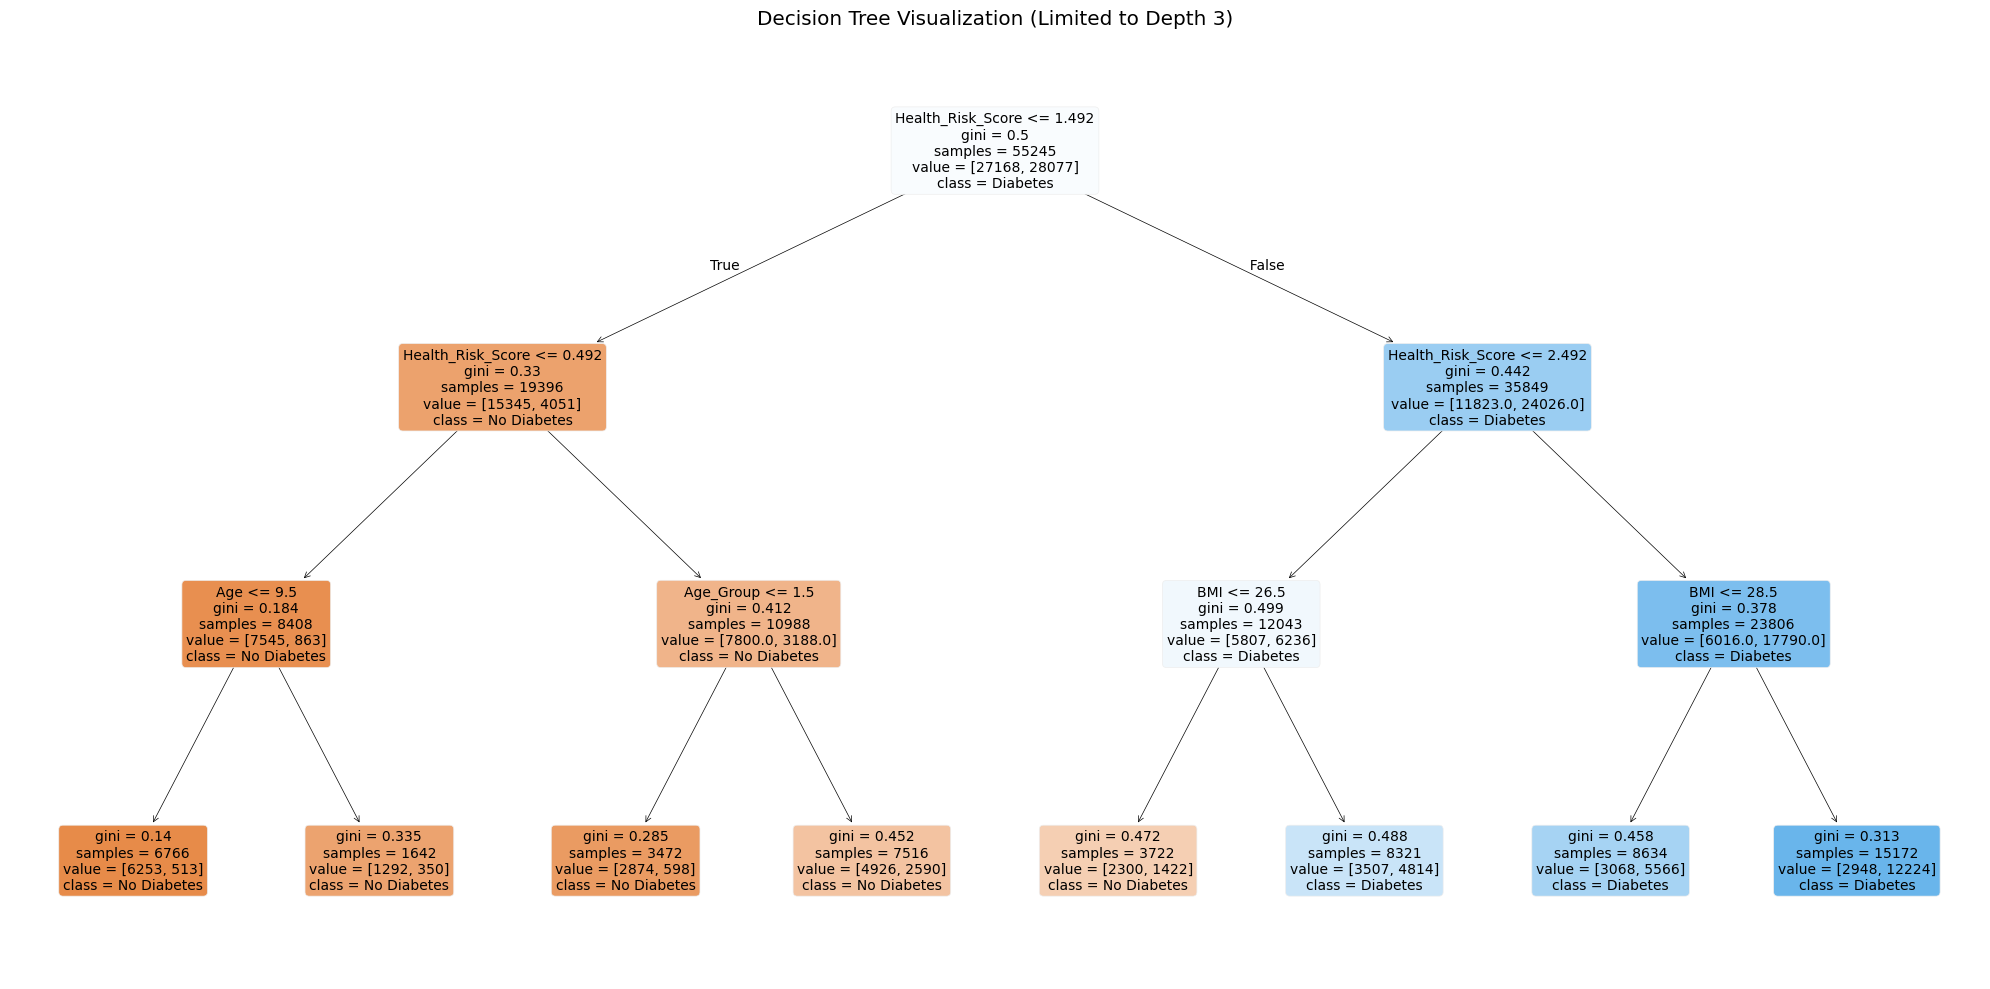

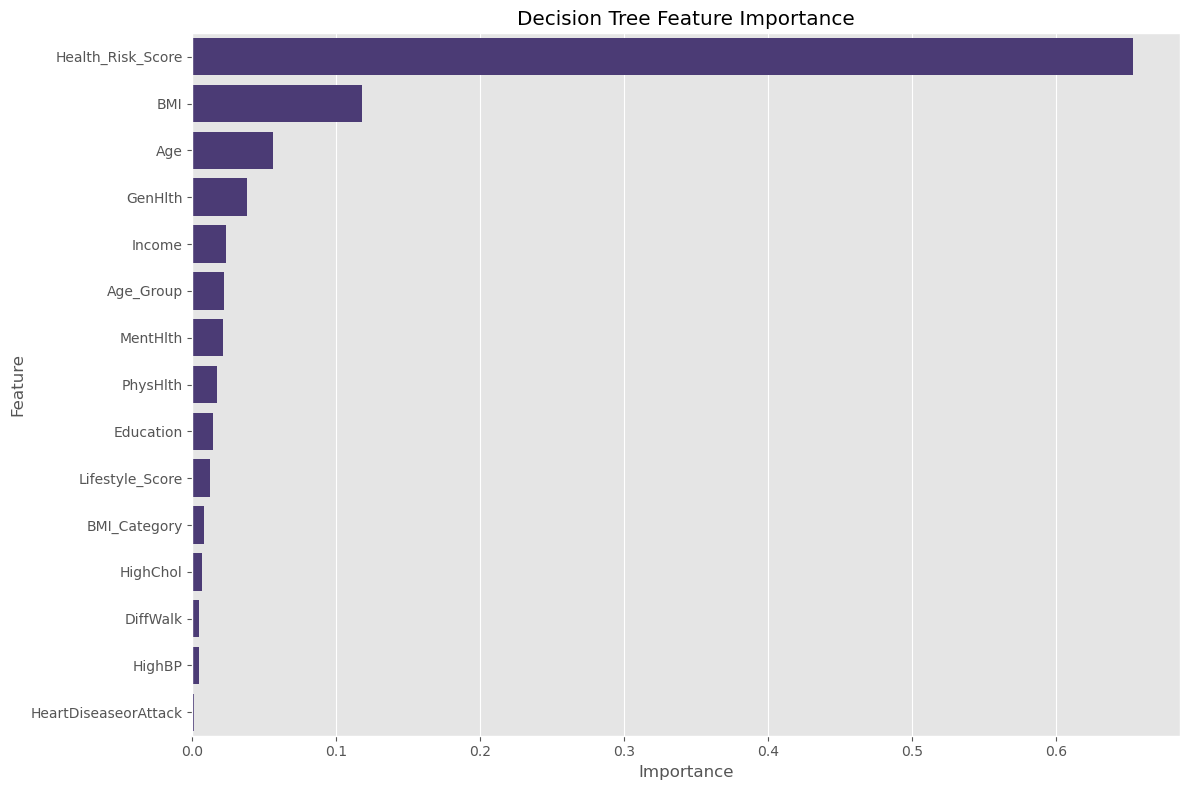

Top 10 most important features:
              Feature  Importance
0   Health_Risk_Score    0.653404
1                 BMI    0.117880
3                 Age    0.055847
2             GenHlth    0.037776
5              Income    0.023534
9           Age_Group    0.021910
13           MentHlth    0.021244
8            PhysHlth    0.017005
11          Education    0.014558
14    Lifestyle_Score    0.012141


In [7]:
# Visualize the decision tree (limit depth for readability)
print("Visualizing Decision Tree...")

# Create a smaller tree for visualization
viz_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
viz_tree.fit(X_train, y_train)

# Plot the tree
plt.figure(figsize=(20, 10))
plot_tree(viz_tree, 
          feature_names=feature_names, 
          class_names=['No Diabetes', 'Diabetes'],
          filled=True, 
          rounded=True, 
          fontsize=10)
plt.title('Decision Tree Visualization (Limited to Depth 3)')
plt.tight_layout()
plt.show()

# Feature importance from the tuned decision tree
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': dt_tuned.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Decision Tree Feature Importance')
plt.tight_layout()
plt.show()

# Print top features
print("Top 10 most important features:")
print(feature_importance.head(10))


## 3. k-Nearest Neighbors (k-NN)

k-NN is a simple, instance-based learning algorithm that classifies new instances based on similarity to known instances. It's sensitive to feature scaling.


Training k-NN model...


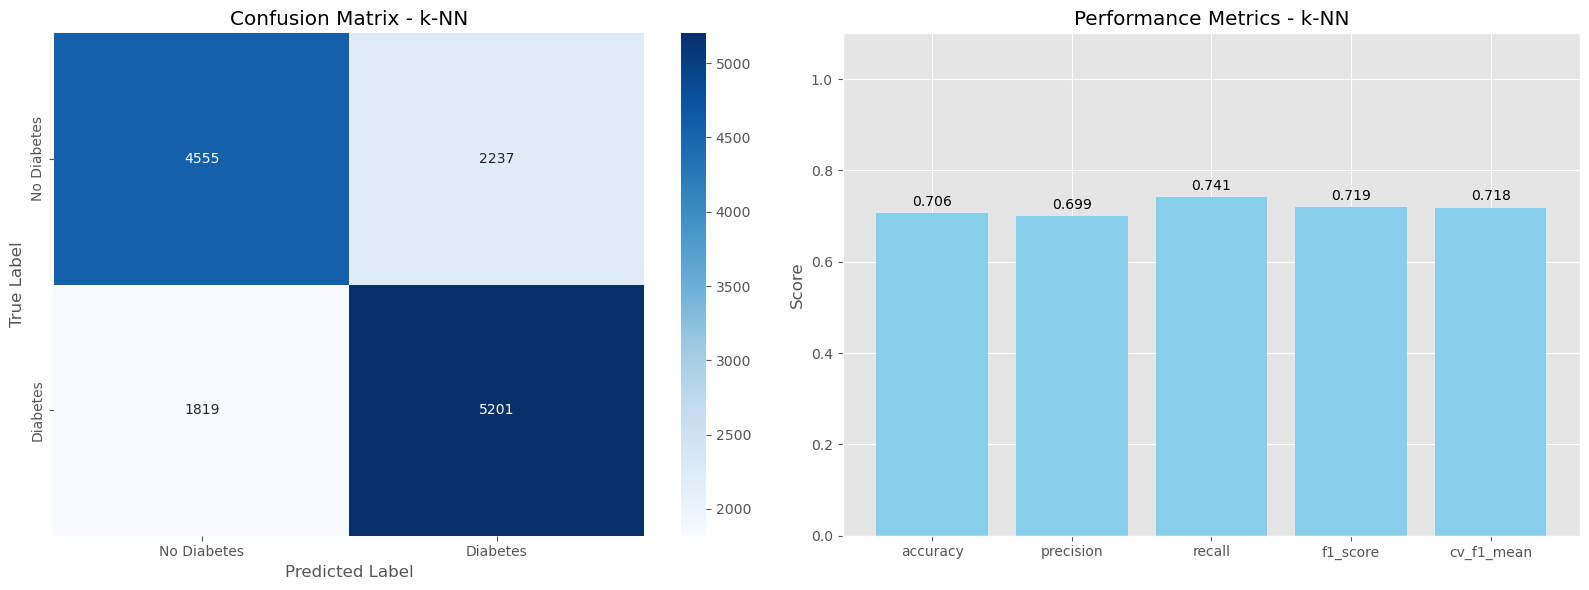

Model: k-NN
Accuracy: 0.7063
Precision: 0.6992
Recall: 0.7409
F1 Score: 0.7195
Cross-Validation F1 Score: 0.7179 ± 0.0048
ROC AUC: 0.7581
Execution Time: 8.0703 seconds

Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.67      0.69      6792
         1.0       0.70      0.74      0.72      7020

    accuracy                           0.71     13812
   macro avg       0.71      0.71      0.71     13812
weighted avg       0.71      0.71      0.71     13812



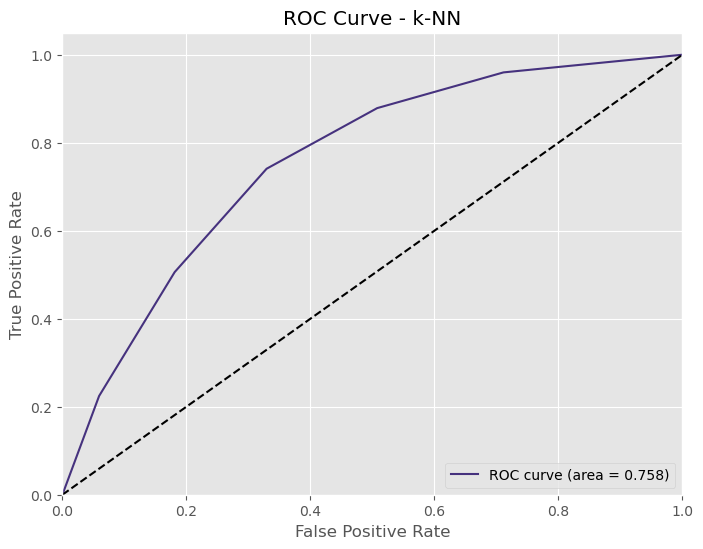

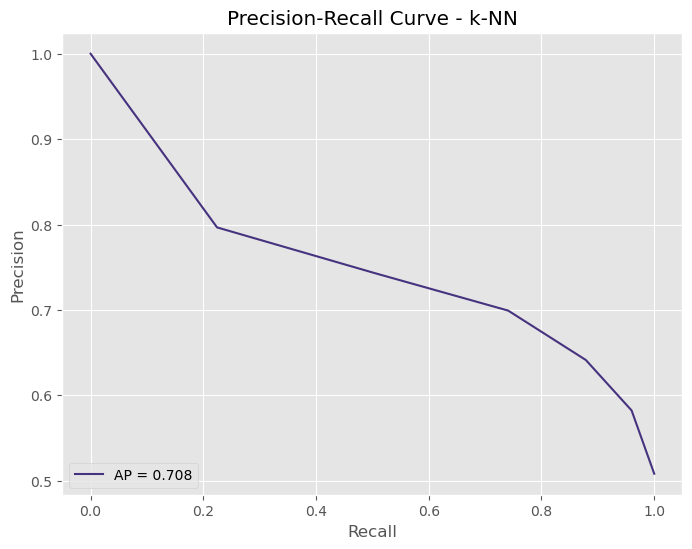

In [8]:
# Create a pipeline with StandardScaler and KNN
# Since KNN is sensitive to feature scaling, we'll use the scaled data
print("Training k-NN model...")

# Create and train the model
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

# Fit the model
knn_pipeline.fit(X_train, y_train)

# Evaluate the model
knn_metrics = evaluate_model(knn_pipeline, X_train, X_test, y_train, y_test, "k-NN")

# Plot results
plot_model_results(knn_metrics, "k-NN")

# Add to results table
results_table.append({
    'Model': 'k-NN',
    'Accuracy': knn_metrics['accuracy'],
    'Precision': knn_metrics['precision'],
    'Recall': knn_metrics['recall'],
    'F1 Score': knn_metrics['f1_score'],
    'CV F1 Score': f"{knn_metrics['cv_f1_mean']:.4f} ± {knn_metrics['cv_f1_std']:.4f}",
    'ROC AUC': knn_metrics['roc_auc'],
    'Execution Time (s)': knn_metrics['execution_time']
})


### 3.1 k-NN with Hyperparameter Tuning


Tuning k-NN hyperparameters...
Fitting 5 folds for each of 84 candidates, totalling 420 fits
Best parameters: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 15, 'classifier__p': 1, 'classifier__weights': 'uniform'}
Best F1 score: 0.7448


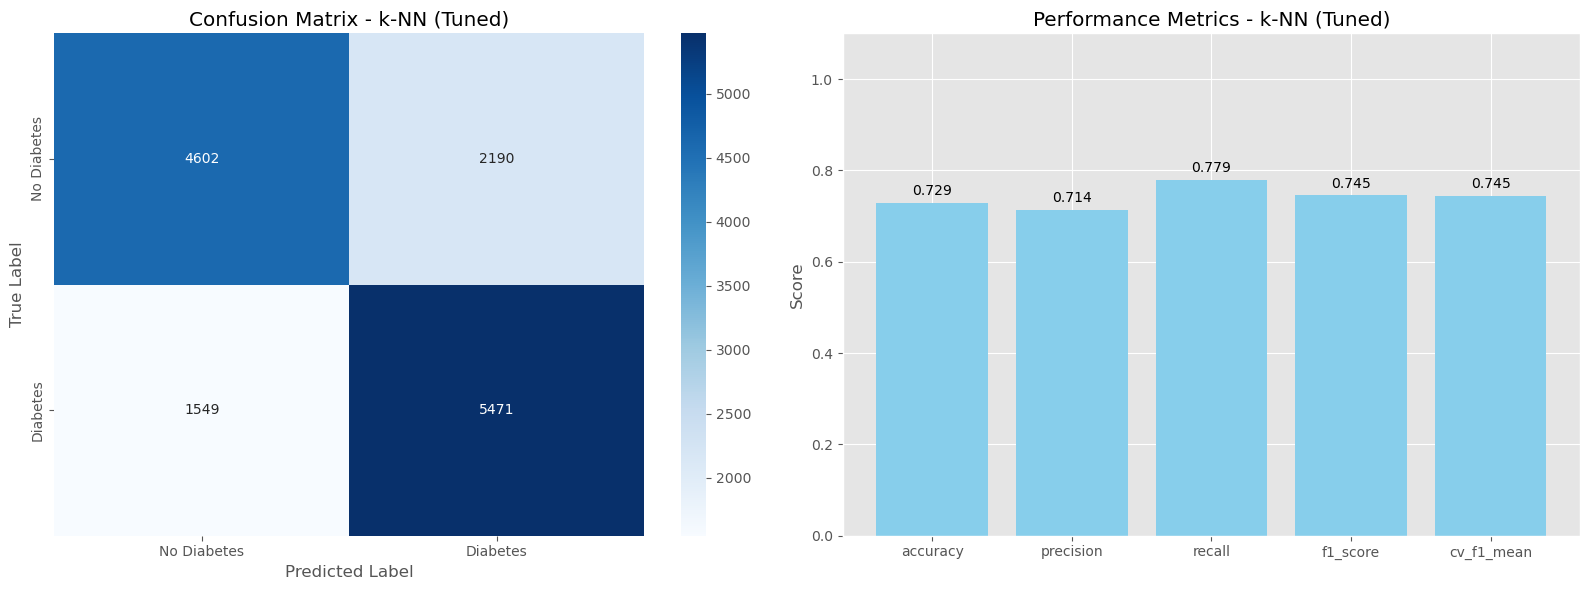

Model: k-NN (Tuned)
Accuracy: 0.7293
Precision: 0.7141
Recall: 0.7793
F1 Score: 0.7453
Cross-Validation F1 Score: 0.7448 ± 0.0053
ROC AUC: 0.7960
Execution Time: 25.6368 seconds

Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.68      0.71      6792
         1.0       0.71      0.78      0.75      7020

    accuracy                           0.73     13812
   macro avg       0.73      0.73      0.73     13812
weighted avg       0.73      0.73      0.73     13812



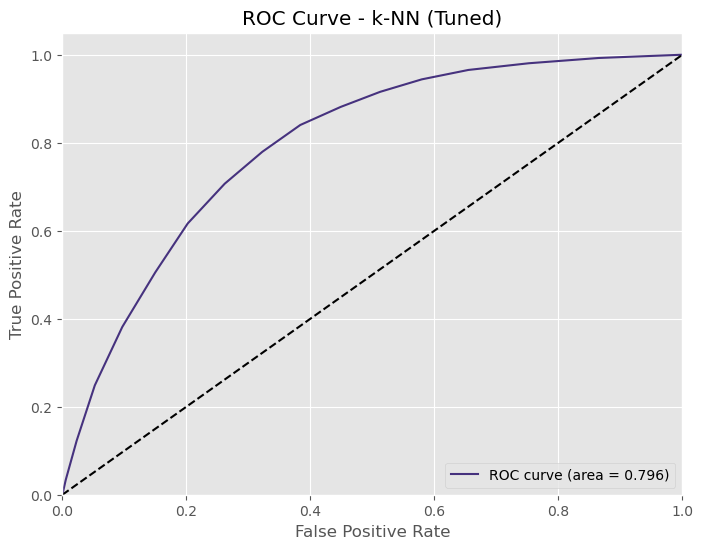

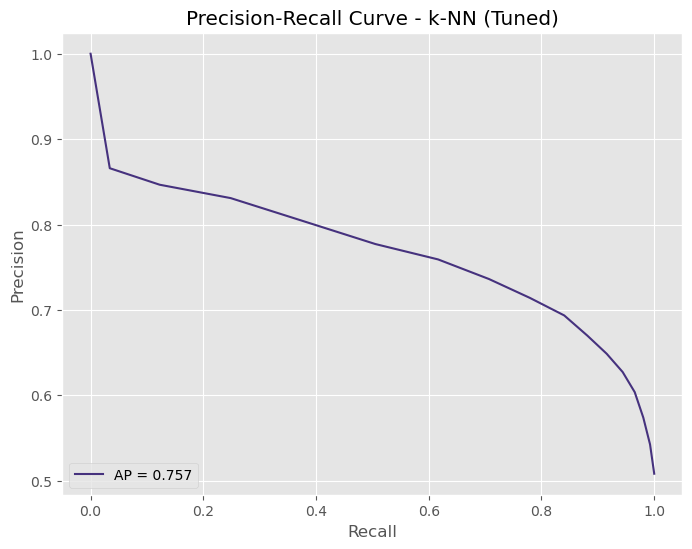

In [5]:
# Tune hyperparameters for k-NN
print("Tuning k-NN hyperparameters...")

# Define the pipeline
knn_tuned_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier())
])

# Define parameter grid
param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski'],
    'classifier__p': [1, 2]  # p=1 for manhattan, p=2 for euclidean
}

# Create GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    knn_tuned_pipeline,
    param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best model
knn_tuned = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best F1 score: {grid_search.best_score_:.4f}")

# Evaluate the tuned model
knn_tuned_metrics = evaluate_model(knn_tuned, X_train, X_test, y_train, y_test, "k-NN (Tuned)")

# Plot results
plot_model_results(knn_tuned_metrics, "k-NN (Tuned)")

# Add to results table
results_table.append({
    'Model': 'k-NN (Tuned)',
    'Accuracy': knn_tuned_metrics['accuracy'],
    'Precision': knn_tuned_metrics['precision'],
    'Recall': knn_tuned_metrics['recall'],
    'F1 Score': knn_tuned_metrics['f1_score'],
    'CV F1 Score': f"{knn_tuned_metrics['cv_f1_mean']:.4f} ± {knn_tuned_metrics['cv_f1_std']:.4f}",
    'ROC AUC': knn_tuned_metrics['roc_auc'],
    'Execution Time (s)': knn_tuned_metrics['execution_time']
})


## 4. Random Forest

Random Forest is an ensemble learning method that builds multiple decision trees and merges their predictions. It typically performs well on a wide range of problems and is less prone to overfitting than individual decision trees.


Training Random Forest model...


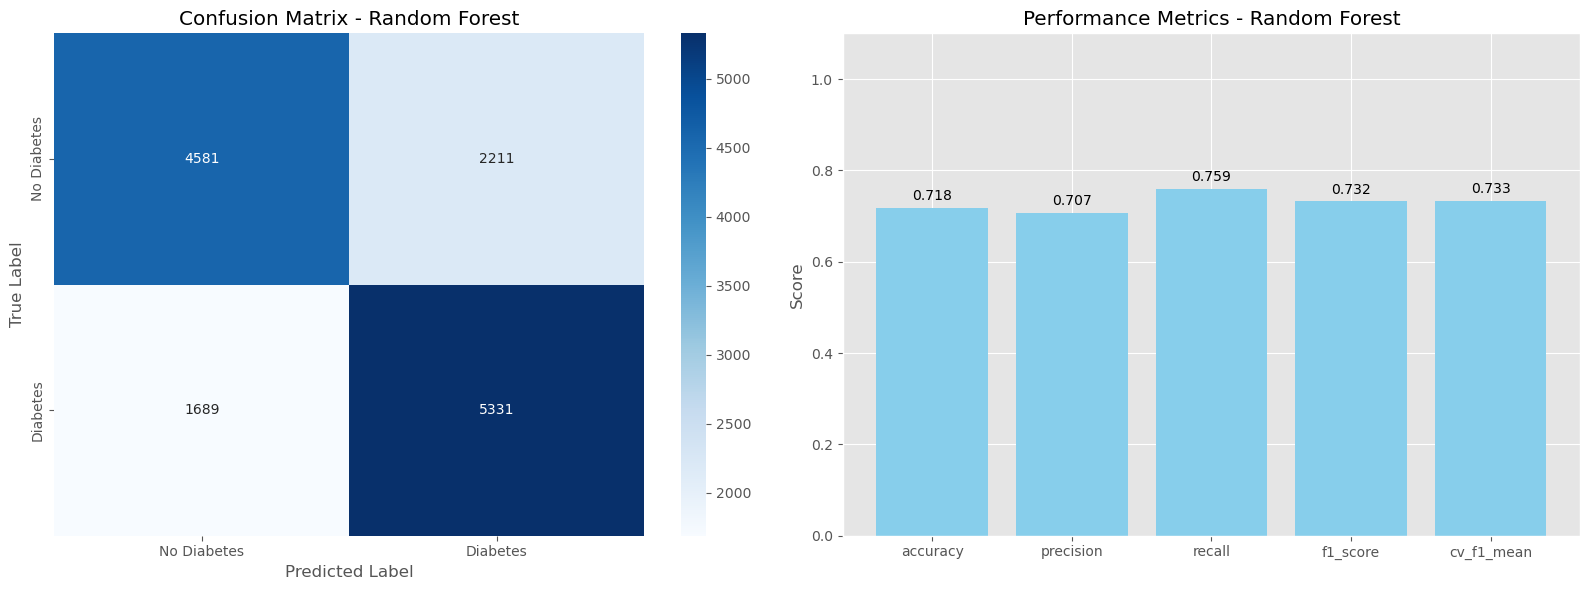

Model: Random Forest
Accuracy: 0.7176
Precision: 0.7068
Recall: 0.7594
F1 Score: 0.7322
Cross-Validation F1 Score: 0.7331 ± 0.0046
ROC AUC: 0.7833
Execution Time: 12.7067 seconds

Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.67      0.70      6792
         1.0       0.71      0.76      0.73      7020

    accuracy                           0.72     13812
   macro avg       0.72      0.72      0.72     13812
weighted avg       0.72      0.72      0.72     13812



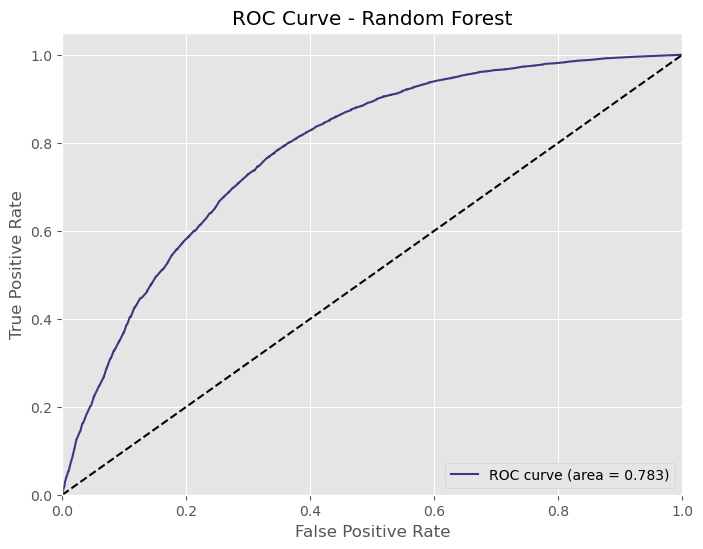

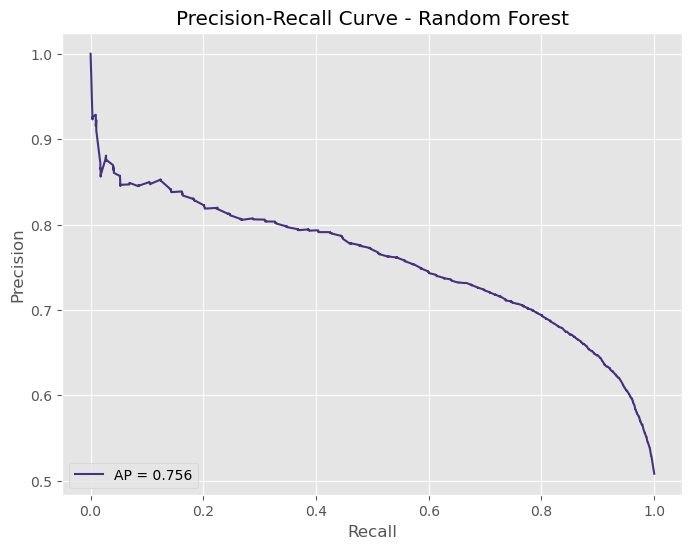

In [6]:
# Random forests don't require feature scaling, so we use the original data
print("Training Random Forest model...")

# Create and train the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate the model
rf_metrics = evaluate_model(rf, X_train, X_test, y_train, y_test, "Random Forest")

# Plot results
plot_model_results(rf_metrics, "Random Forest")

# Add to results table
results_table.append({
    'Model': 'Random Forest',
    'Accuracy': rf_metrics['accuracy'],
    'Precision': rf_metrics['precision'],
    'Recall': rf_metrics['recall'],
    'F1 Score': rf_metrics['f1_score'],
    'CV F1 Score': f"{rf_metrics['cv_f1_mean']:.4f} ± {rf_metrics['cv_f1_std']:.4f}",
    'ROC AUC': rf_metrics['roc_auc'],
    'Execution Time (s)': rf_metrics['execution_time']
})


### 4.1 Random Forest with Hyperparameter Tuning


Tuning Random Forest hyperparameters...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best F1 score: 0.7510


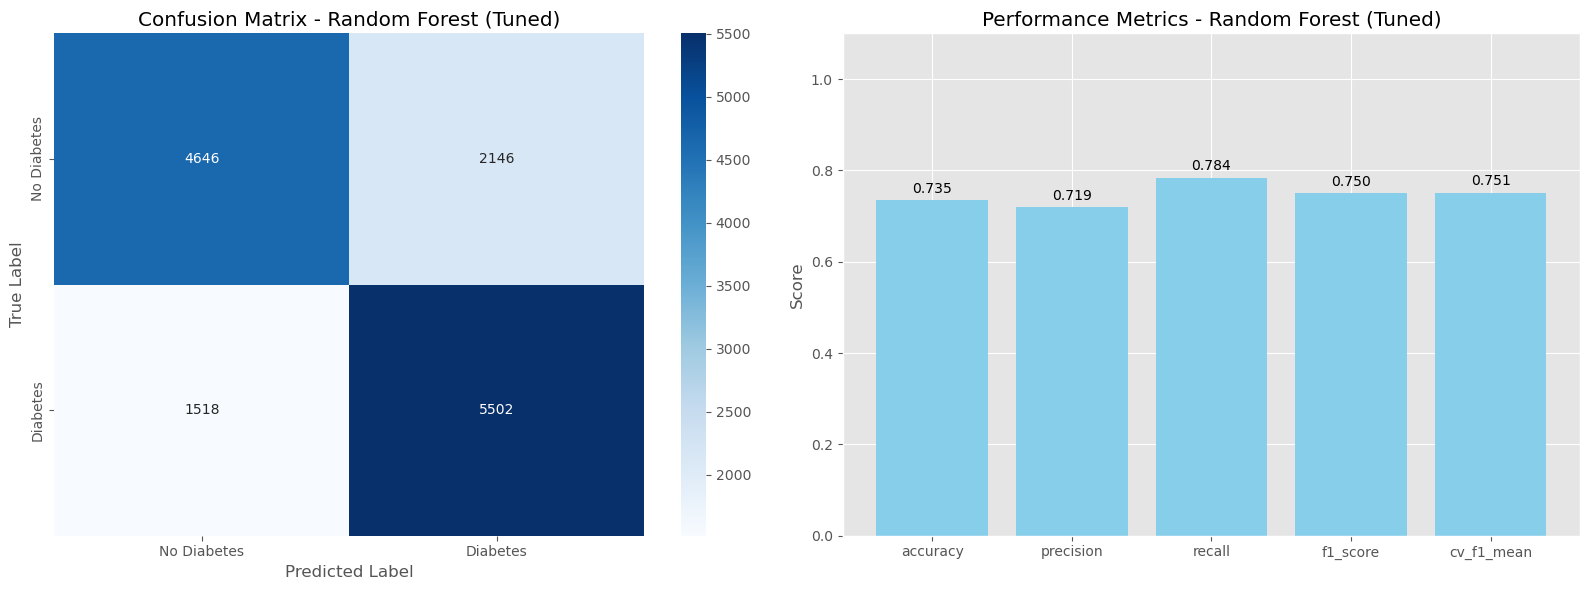

Model: Random Forest (Tuned)
Accuracy: 0.7347
Precision: 0.7194
Recall: 0.7838
F1 Score: 0.7502
Cross-Validation F1 Score: 0.7510 ± 0.0039
ROC AUC: 0.8070
Execution Time: 32.2186 seconds

Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.68      0.72      6792
         1.0       0.72      0.78      0.75      7020

    accuracy                           0.73     13812
   macro avg       0.74      0.73      0.73     13812
weighted avg       0.74      0.73      0.73     13812



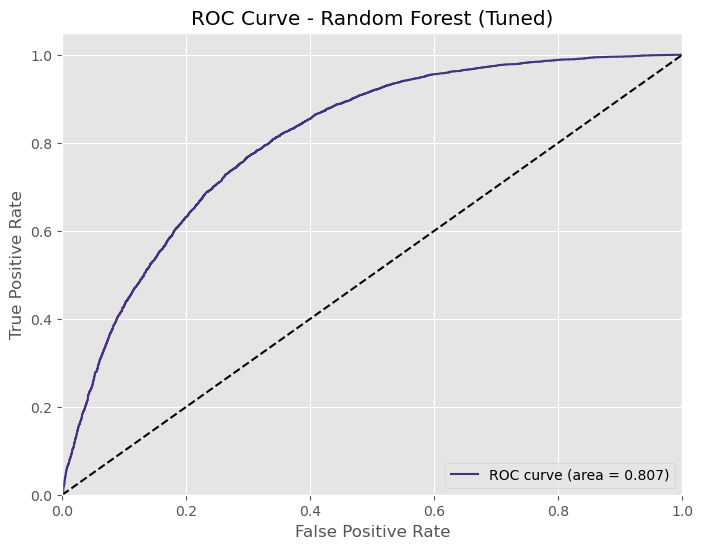

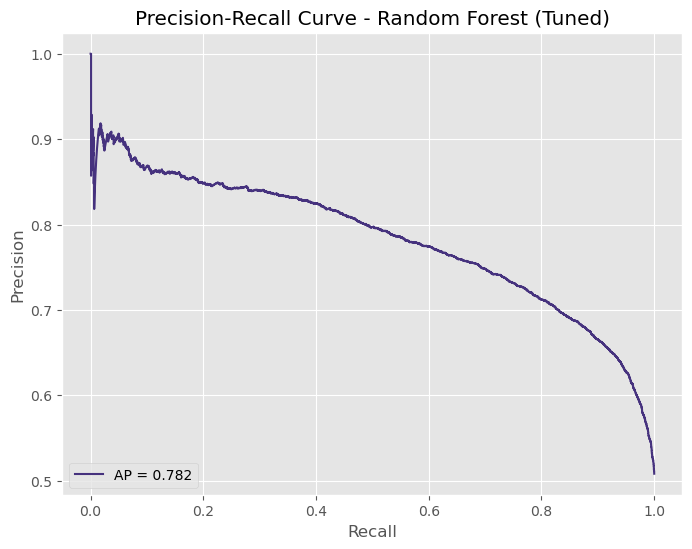

In [7]:
# Tune hyperparameters for Random Forest
print("Tuning Random Forest hyperparameters...")

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create GridSearchCV with a smaller parameter grid for efficiency
smaller_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Create GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    smaller_param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best model
rf_tuned = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best F1 score: {grid_search.best_score_:.4f}")

# Evaluate the tuned model
rf_tuned_metrics = evaluate_model(rf_tuned, X_train, X_test, y_train, y_test, "Random Forest (Tuned)")

# Plot results
plot_model_results(rf_tuned_metrics, "Random Forest (Tuned)")

# Add to results table
results_table.append({
    'Model': 'Random Forest (Tuned)',
    'Accuracy': rf_tuned_metrics['accuracy'],
    'Precision': rf_tuned_metrics['precision'],
    'Recall': rf_tuned_metrics['recall'],
    'F1 Score': rf_tuned_metrics['f1_score'],
    'CV F1 Score': f"{rf_tuned_metrics['cv_f1_mean']:.4f} ± {rf_tuned_metrics['cv_f1_std']:.4f}",
    'ROC AUC': rf_tuned_metrics['roc_auc'],
    'Execution Time (s)': rf_tuned_metrics['execution_time']
})


### 4.2 Random Forest Feature Importance


Extracting feature importance from Random Forest...


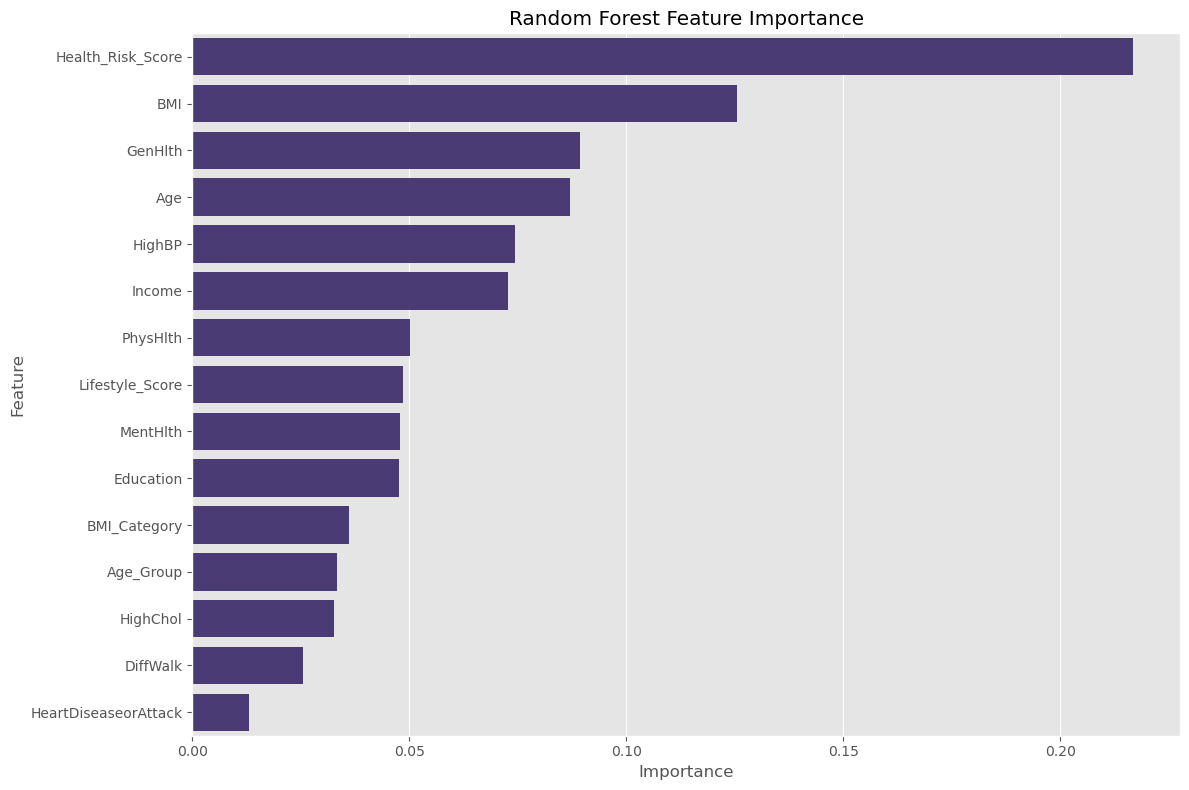

Top 10 most important features:
              Feature  Importance
0   Health_Risk_Score    0.216759
1                 BMI    0.125502
2             GenHlth    0.089388
3                 Age    0.087050
4              HighBP    0.074335
5              Income    0.072639
8            PhysHlth    0.050060
14    Lifestyle_Score    0.048440
13           MentHlth    0.047758
11          Education    0.047508


In [8]:
# Extract feature importance from Random Forest
print("Extracting feature importance from Random Forest...")

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_tuned.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

# Print top features
print("Top 10 most important features:")
print(feature_importance.head(10))


## 5. Support Vector Machine (SVM)

Support Vector Machines work by finding the hyperplane that best separates the classes. They're effective in high-dimensional spaces and are sensitive to feature scaling.


Training SVM model...


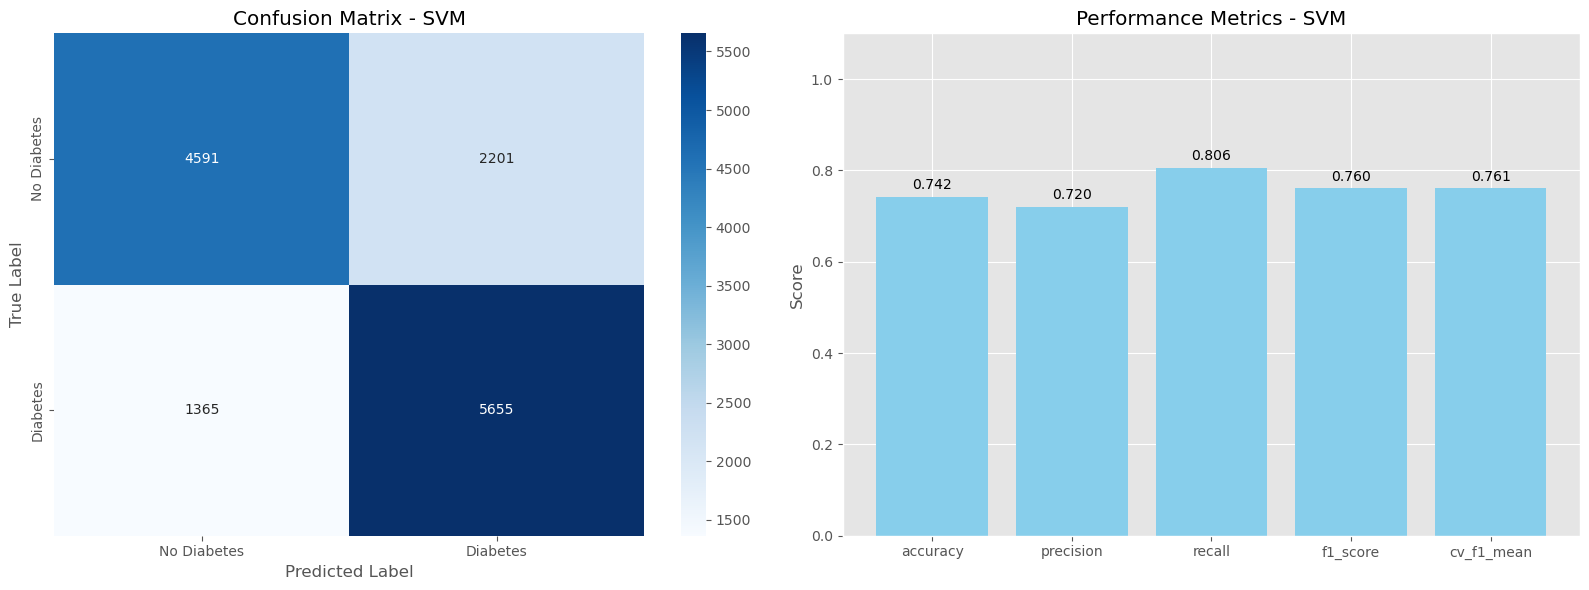

Model: SVM
Accuracy: 0.7418
Precision: 0.7198
Recall: 0.8056
F1 Score: 0.7603
Cross-Validation F1 Score: 0.7607 ± 0.0045
ROC AUC: 0.7992
Execution Time: 1260.0026 seconds

Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.68      0.72      6792
         1.0       0.72      0.81      0.76      7020

    accuracy                           0.74     13812
   macro avg       0.75      0.74      0.74     13812
weighted avg       0.74      0.74      0.74     13812



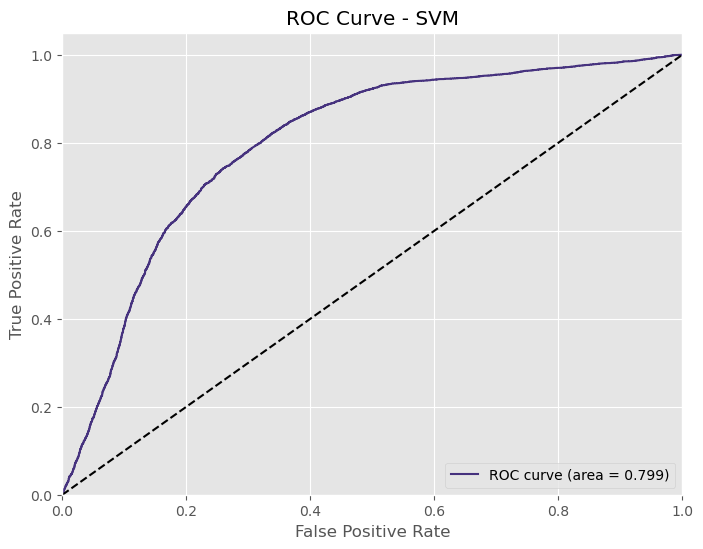

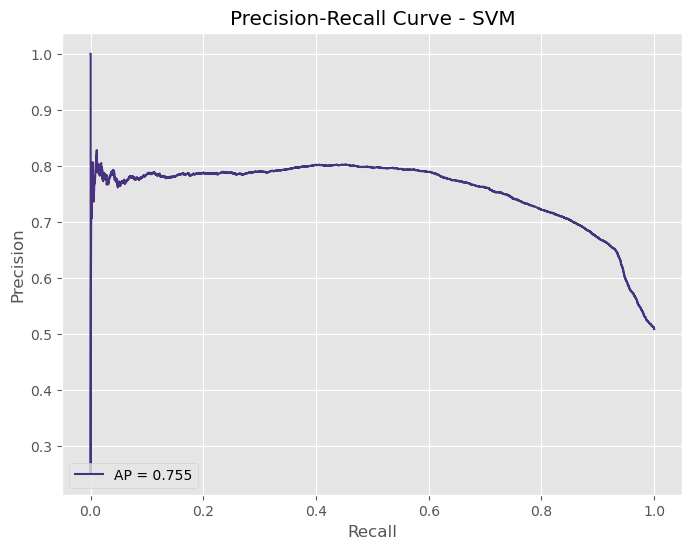

In [9]:
# Create a pipeline with StandardScaler and SVM
# Since SVM is sensitive to feature scaling, we'll use the scaled data
print("Training SVM model...")

# Create and train the model
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(probability=True, random_state=42))
])

# Fit the model
svm_pipeline.fit(X_train, y_train)

# Evaluate the model
svm_metrics = evaluate_model(svm_pipeline, X_train, X_test, y_train, y_test, "SVM")

# Plot results
plot_model_results(svm_metrics, "SVM")

# Add to results table
results_table.append({
    'Model': 'SVM',
    'Accuracy': svm_metrics['accuracy'],
    'Precision': svm_metrics['precision'],
    'Recall': svm_metrics['recall'],
    'F1 Score': svm_metrics['f1_score'],
    'CV F1 Score': f"{svm_metrics['cv_f1_mean']:.4f} ± {svm_metrics['cv_f1_std']:.4f}",
    'ROC AUC': svm_metrics['roc_auc'],
    'Execution Time (s)': svm_metrics['execution_time']
})


Tuning SVM hyperparameters...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Best F1 score: 0.7626


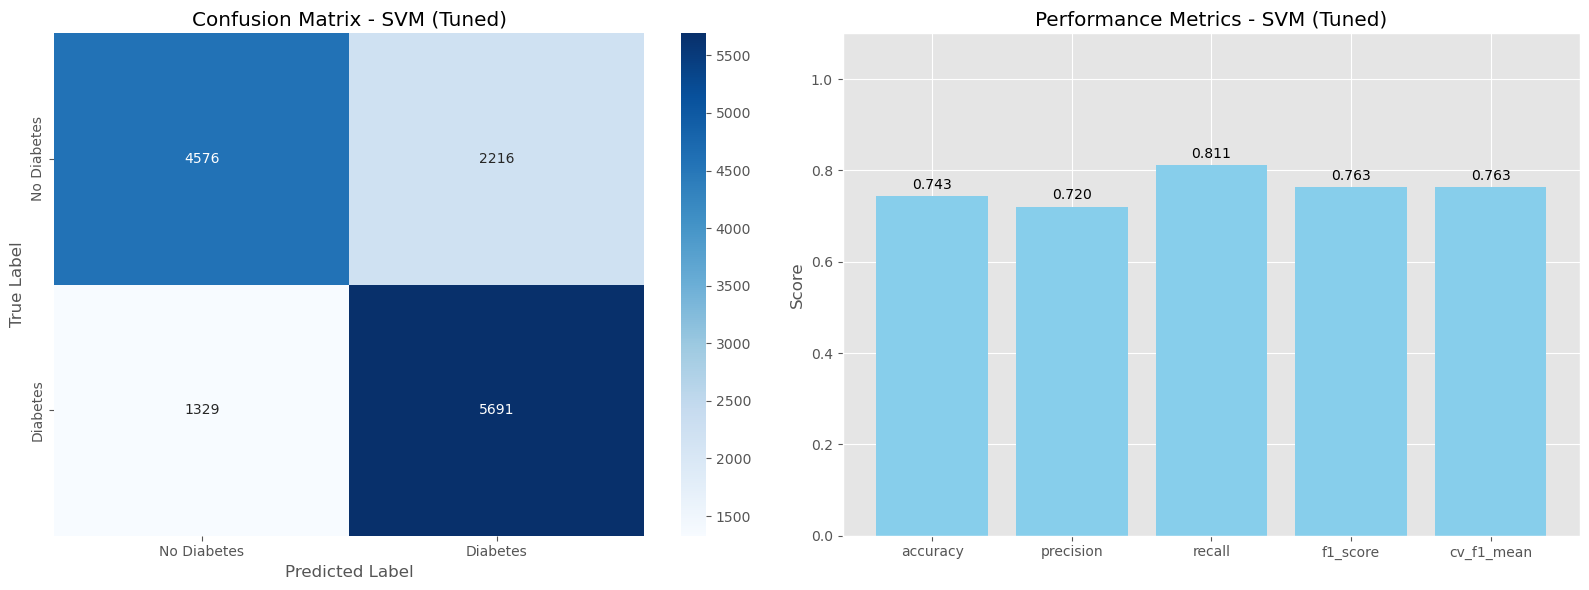

Model: SVM (Tuned)
Accuracy: 0.7433
Precision: 0.7197
Recall: 0.8107
F1 Score: 0.7625
Cross-Validation F1 Score: 0.7626 ± 0.0048
ROC AUC: 0.8076
Execution Time: 891.3692 seconds

Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.67      0.72      6792
         1.0       0.72      0.81      0.76      7020

    accuracy                           0.74     13812
   macro avg       0.75      0.74      0.74     13812
weighted avg       0.75      0.74      0.74     13812



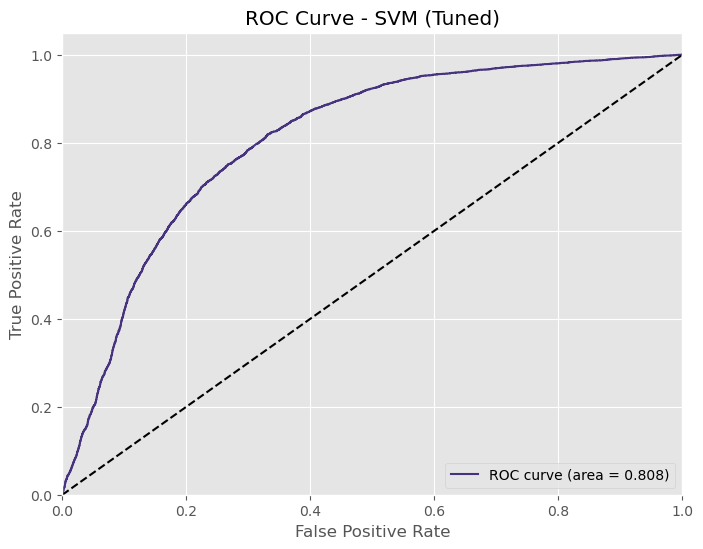

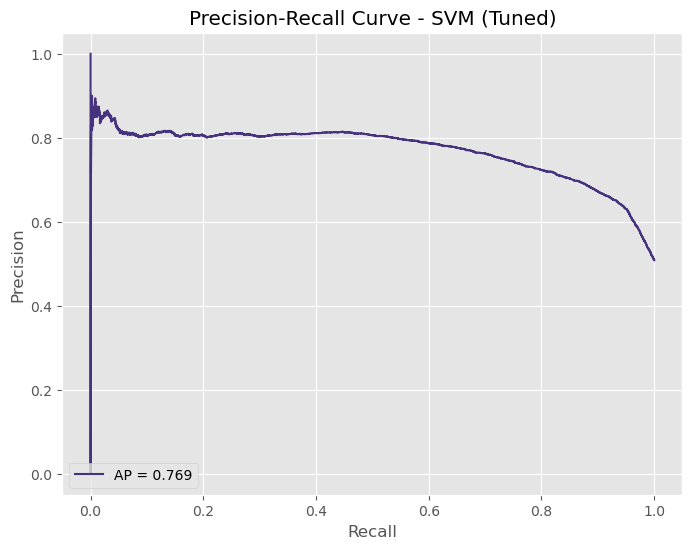

In [11]:
# Tune hyperparameters for SVM
print("Tuning SVM hyperparameters...")

# Define the pipeline
svm_tuned_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(probability=True, random_state=42))
])

# Define parameter grid
param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': ['scale', 'auto', 0.01, 0.1],
    'classifier__kernel': ['rbf', 'linear', 'poly']
}

# Create GridSearchCV with a smaller parameter grid for efficiency
smaller_param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': ['scale', 'auto'],
    'classifier__kernel': ['rbf', 'linear']
}

# Create GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    svm_tuned_pipeline,
    smaller_param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best model
svm_tuned = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best F1 score: {grid_search.best_score_:.4f}")

# Evaluate the tuned model
svm_tuned_metrics = evaluate_model(svm_tuned, X_train, X_test, y_train, y_test, "SVM (Tuned)")

# Plot results
plot_model_results(svm_tuned_metrics, "SVM (Tuned)")

# Add to results table
results_table.append({
    'Model': 'SVM (Tuned)',
    'Accuracy': svm_tuned_metrics['accuracy'],
    'Precision': svm_tuned_metrics['precision'],
    'Recall': svm_tuned_metrics['recall'],
    'F1 Score': svm_tuned_metrics['f1_score'],
    'CV F1 Score': f"{svm_tuned_metrics['cv_f1_mean']:.4f} ± {svm_tuned_metrics['cv_f1_std']:.4f}",
    'ROC AUC': svm_tuned_metrics['roc_auc'],
    'Execution Time (s)': svm_tuned_metrics['execution_time']
})


Model Performance Comparison:


,Model,Accuracy,Precision,Recall,F1 Score,CV F1 Score,ROC AUC,Execution Time (s)
0,k-NN (Tuned),0.729293,0.714137,0.779345,0.745317,0.7448 ± 0.0053,0.795986,25.636785
1,Random Forest,0.717637,0.706842,0.759402,0.732180,0.7331 ± 0.0046,0.783278,12.706682
2,Random Forest (Tuned),0.734723,0.719404,0.783761,0.750205,0.7510 ± 0.0039,0.807013,32.218558
3,SVM,0.741819,0.719832,0.805556,0.760285,0.7607 ± 0.0045,0.799211,1260.002586
4,Logistic Regression (Tuned),0.743194,0.735202,0.773219,0.753732,0.7523 ± 0.0040,0.815272,0.591071
5,SVM (Tuned),0.743339,0.719742,0.810684,0.762511,0.7626 ± 0.0048,0.807631,891.369213


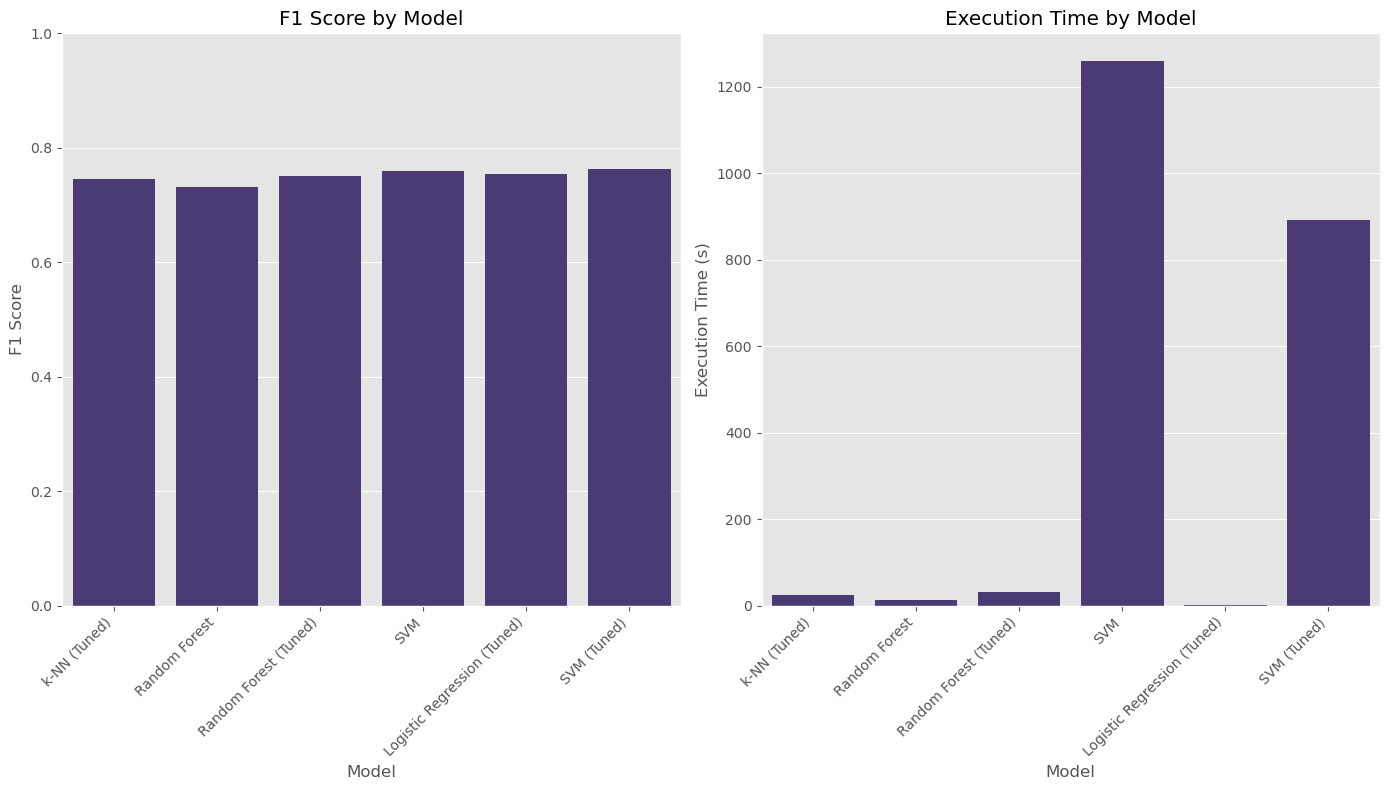

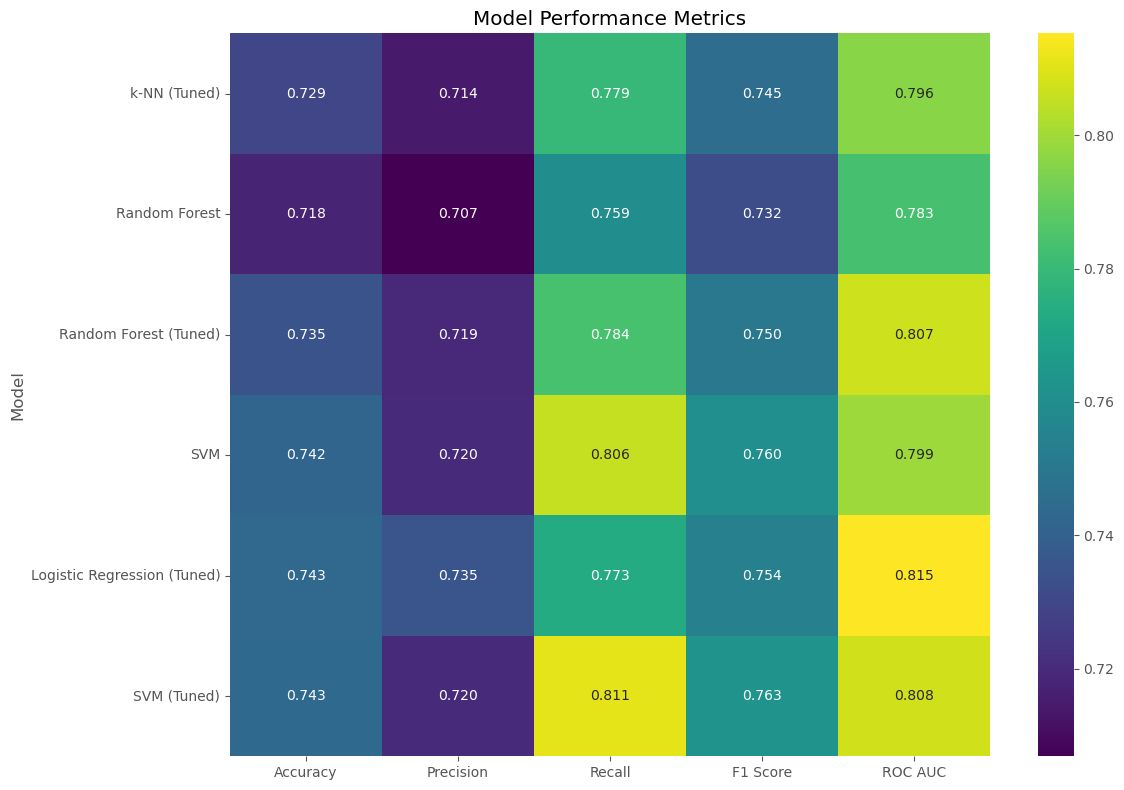

Best model based on F1 score: SVM (Tuned) (F1 = 0.7625)


In [14]:
# Create a DataFrame from the results table
results_df = pd.DataFrame(results_table)

# Display the results
print("Model Performance Comparison:")
display(results_df)

# Plot model comparison
plt.figure(figsize=(14, 8))

# Plot F1 scores
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='F1 Score', data=results_df)
plt.title('F1 Score by Model')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)

# Plot execution times
plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='Execution Time (s)', data=results_df)
plt.title('Execution Time by Model')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Create a heatmap of metrics
metrics_heatmap = results_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']]
plt.figure(figsize=(12, 8))
sns.heatmap(metrics_heatmap, annot=True, cmap='viridis', fmt='.3f')
plt.title('Model Performance Metrics')
plt.tight_layout()
plt.show()

# Find the best model based on F1 score
best_model_idx = results_df['F1 Score'].idxmax()
best_model = results_df.loc[best_model_idx, 'Model']
best_f1 = results_df.loc[best_model_idx, 'F1 Score']

print(f"Best model based on F1 score: {best_model} (F1 = {best_f1:.4f})")


In [13]:
# Save the best model
print(f"Saving the best model: {best_model}")

# Get the best model object
if best_model == 'Logistic Regression (Tuned)':
    best_model_obj = lr_tuned
elif best_model == 'Decision Tree (Tuned)':
    best_model_obj = dt_tuned
elif best_model == 'k-NN (Tuned)':
    best_model_obj = knn_tuned
elif best_model == 'Random Forest (Tuned)':
    best_model_obj = rf_tuned
elif best_model == 'SVM (Tuned)':
    best_model_obj = svm_tuned
else:
    # Default to the model with highest F1 score if name doesn't match
    print("Model name not found, saving the Random Forest model as default")
    best_model_obj = rf_tuned
    best_model = "Random Forest (Tuned)"

# Save model and results
model_results = {
    'model': best_model_obj,
    'model_name': best_model,
    'feature_names': feature_names,
    'metrics': {
        'accuracy': best_f1,
        'precision': results_df.loc[best_model_idx, 'Precision'],
        'recall': results_df.loc[best_model_idx, 'Recall'],
        'f1_score': best_f1,
        'roc_auc': results_df.loc[best_model_idx, 'ROC AUC']
    },
    'results_table': results_df
}

# Create models directory if it doesn't exist
import os
os.makedirs('models', exist_ok=True)

# Convert model name to a safe filename
model_filename = f"best_model_{str(best_model).replace(' ', '_').lower()}.pkl"

# Save the model
with open(f'models/{model_filename}', 'wb') as f:
    pickle.dump(model_results, f)

print(f"Model saved to models/{model_filename}")


Saving the best model: SVM (Tuned)
Model saved to models/best_model_svm_(tuned).pkl
